In [1]:
import string
from collections import Counter
import re
import nltk
from unidecode import unidecode

In [2]:
# Load stopwords into set (from http://www.ranks.nl/stopwords)
with open('stopwords') as f:
    sw = f.read()
stopwords = set(sw.split())

In [3]:
def clean_text(_txt):
    # string.punctuaction => '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    punc = string.punctuation
    trans = {ord(c): ' ' for c in punc}
    trans[ord("'")] = None

    s = unidecode(_txt).translate(trans)
    s = re.sub(r'\d+', '', s)
    return ' '.join(s.lower().split())

def remove_stopwords(_txt):
    return ' '.join(w for w in _txt.split() if not w in stopwords)

In [4]:
with open('bounties_project_overview_for_research.txt') as f:
    txt = f.read()

In [5]:
# Remove questions
questions_raw = '''What type of apps do you build:
Eg: Are they primarily blockchain-based? Blockchain backend with a "regular" web front-end? Front-end that uses the blockchain directly via Metamask et al?
How do you test things which interact with the blockchain:
Automated testing? How do the facilitate manual testing? (to get an idea how sophisticated their dev process is)
Brief walk through of the tools you use daily
If not already mentioned, are there any libraries you rely on regularly?
What isn't possible with current tools, but would be nice
Try to remember the last time you developed a feature for ethereum and you ran into some unexpected obstacle. What was it? How did you feel?
This Q used to be: what is most frustrating about developing on ETH? (changed so we’re not asking a leading question).
Are you running into problems with any of the following:
What tool’s / libraries are most frustrating
How could they be improved
What surprised you on the other end, what was way easier than expected?
What process do you use for validating the security of your smart contracts?
What was the hardest part about learning to develop with Ethereum
What was the first thing you built related to Ethereum, and when did you build it? (NEW)
What applications are you most excited about in the near term (ie. what do you think will be working soon)
Who are other people you think we should talk to (alternative:  Who is the best developer you know)
What other questions should we be asking?
What really pisses you off about ETH development
'''
questions = []
for q in questions_raw.split('\n'):
    questions.append(clean_text(q))

def remove_questions(_txt):
    for q in questions:
        _txt = re.sub(q, '', _txt)
    return _txt

In [6]:
with open('contacts.txt') as f:
    contacts_raw = f.read()

contacts = set()
for c in contacts_raw.split('\n'):
    m = re.match('[0-9]+\. ([a-zA-Z ]+).*', c)
    if m is not None:
        contacts.add(m.group(1).lower().strip())

In [7]:
# Chain the cleanup
txt2 = remove_stopwords(remove_questions(clean_text(txt)))

# Bigrams

In [10]:
bigrams = nltk.bigrams(nltk.word_tokenize(txt2))
counter = Counter()
for b in bigrams:
    counter[b] += 1

In [11]:
counter.most_common(20)

[(('e', 'g'), 96),
 (('smart', 'contracts'), 73),
 (('smart', 'contract'), 58),
 (('right', 'now'), 45),
 (('state', 'channels'), 40),
 (('gas', 'limit'), 34),
 (('open', 'source'), 32),
 (('unit', 'tests'), 24),
 (('best', 'practices'), 24),
 (('code', 'coverage'), 21),
 (('front', 'end'), 21),
 (('dont', 'know'), 20),
 (('ui', 'issues'), 20),
 (('web', 'js'), 19),
 (('developing', 'eth'), 18),
 (('make', 'sure'), 18),
 (('frustrating', 'developing'), 17),
 (('geth', 'parity'), 17),
 (('chain', 'computation'), 17),
 (('json', 'rpc'), 17)]

# Trigrams

In [12]:
bigrams = nltk.trigrams(nltk.word_tokenize(txt2))
counter = Counter()
for b in bigrams:
    counter[b] += 1

In [13]:
counter.most_common(20)

[(('frustrating', 'developing', 'eth'), 17),
 (('specifically', 'talk', 'ui'), 15),
 (('talk', 'ui', 'issues'), 15),
 (('ui', 'issues', 'scaling'), 15),
 (('developing', 'eth', 'specifically'), 14),
 (('eth', 'specifically', 'talk'), 14),
 (('https', 'github', 'com'), 14),
 (('hardest', 'part', 'teaching'), 9),
 (('code', 'coverage', 'tool'), 7),
 (('chain', 'computation', 'state'), 6),
 (('computation', 'state', 'channels'), 6),
 (('people', 'think', 'talk'), 6),
 (('writing', 'smart', 'contracts'), 6),
 (('tools', 'libraries', 'frameworks'), 6),
 (('static', 'analysis', 'tools'), 5),
 (('ui', 'issues', 'struggled'), 5),
 (('exist', 'right', 'now'), 5),
 (('x', 'code', 'coverage'), 4),
 (('questions', 'frustrating', 'developing'), 4),
 (('gas', 'limit', 'chain'), 4)]

# LDA

In [8]:
# Separate inteview into docs (nees more work?)
docs_raw = []
current = None

cnt = 0

for l in txt.split('\n'):
    if l == '%%%%':
        if current is not None and len(current) > 1:
            docs_raw.append(current)
        current = []
    if current is not None and l != '':
        current.append(l)

if current is not None and len(current) > 1:
    docs_raw.append(current)

docs = []
for doc in docs_raw:
    docs.append(remove_stopwords(remove_questions(clean_text('\n'.join(doc)))).split())

In [9]:
from gensim import corpora, models, similarities

In [10]:
gdict = corpora.Dictionary(docs)

In [11]:
corpus = [gdict.doc2bow(doc) for doc in docs]

In [12]:
tfidf = models.TfidfModel(corpus)

In [28]:
corpus_tfidf = tfidf[corpus]

In [29]:
lsi = models.LsiModel(corpus_tfidf, id2word=gdict, num_topics=10)

In [30]:
lsi.show_topics()

[(0,
  '0.076*"bounty" + 0.074*"geth" + 0.072*"remix" + 0.072*"data" + 0.071*"parity" + 0.067*"really" + 0.066*"tools" + 0.063*"metamask" + 0.063*"need" + 0.060*"chain"'),
 (1,
  '-0.406*"wasm" + -0.135*"ewasm" + 0.115*"john" + -0.108*"opcodes" + 0.102*"marcus" + -0.081*"stu" + -0.081*"stack" + 0.081*"metamask" + -0.080*"greg" + -0.080*"easily"'),
 (2,
  '-0.227*"marcus" + -0.187*"john" + -0.143*"ricardo" + -0.118*"david" + -0.110*"remix" + -0.110*"limit" + 0.101*"erc" + -0.092*"computation" + -0.089*"ethers" + -0.081*"frustrating"'),
 (3,
  '-0.185*"wasm" + -0.153*"david" + 0.138*"zeppelin" + -0.115*"chainsafe" + -0.111*"geth" + -0.103*"stu" + -0.094*"greg" + -0.093*"metamask" + -0.093*"phishing" + -0.088*"parity"'),
 (4,
  '-0.141*"john" + -0.133*"bounty" + -0.112*"phishing" + -0.097*"gitcoin" + 0.092*"auction" + -0.091*"open" + 0.085*"matt" + 0.083*"ricardo" + -0.082*"mew" + 0.081*"whisper"'),
 (5,
  '-0.215*"wasm" + 0.146*"david" + 0.131*"land" + 0.131*"chainsafe" + -0.128*"ewasm" 

In [21]:
lda = models.ldamodel.LdaModel(corpus, id2word=gdict, num_topics=100)

In [25]:
lda.top_topics(corpus)

[([(0.013396365, 'people'),
   (0.007264744, 'ethereum'),
   (0.0068792063, 'need'),
   (0.006706207, 'data'),
   (0.005934115, 'will'),
   (0.005377711, 'really'),
   (0.005376987, 'blockchain'),
   (0.0052768486, 'just'),
   (0.005252305, 'get'),
   (0.0050503598, 'code'),
   (0.00497197, 'solidity'),
   (0.0049276785, 'can'),
   (0.00482776, 'contract'),
   (0.0047478634, 'using'),
   (0.0042986125, 'tools'),
   (0.004271784, 'time'),
   (0.003954549, 'work'),
   (0.0038757112, 'use'),
   (0.0038278431, 'things'),
   (0.0036884, 'dont')],
  -0.2962725218390776),
 ([(0.011464867, 'people'),
   (0.009504427, 'ethereum'),
   (0.007797378, 'tools'),
   (0.0073257666, 'solidity'),
   (0.0065456415, 'web'),
   (0.006084652, 'time'),
   (0.005782967, 'contracts'),
   (0.0056373724, 'need'),
   (0.005461871, 'js'),
   (0.005392391, 'working'),
   (0.0053811683, 'can'),
   (0.005283525, 'blockchain'),
   (0.005198156, 'work'),
   (0.005181165, 'good'),
   (0.0050225845, 'dont'),
   (0.004855

# Q&A

 * Slicing up interviews into questions

In [34]:
sents = nltk.sent_tokenize(txt)

In [115]:
q_and_a = {}
prev_bucket = None
for sent in sents:
    clean_sent = remove_stopwords(clean_text(sent))
    if not clean_sent:
        continue
    if sent.startswith('What') or sent.endswith('?'):
        prev_bucket = q_and_a.setdefault(clean_sent, set())
    elif prev_bucket is not None and clean_sent:
        prev_bucket.add(clean_sent)
        prev_bucket = None

In [116]:
q_and_a_sorted = sorted([(-len(v), k) for k, v in q_and_a.items()])

In [118]:
q_and_a_docs = []
for _, k in q_and_a_sorted[:9]:
    q_and_a_docs.append([w for a in q_and_a[k] for w in a.split()])

In [121]:
q_and_a_gdict = corpora.Dictionary(q_and_a_docs)
q_and_a_corpus = [q_and_a_gdict.doc2bow(doc) for doc in q_and_a_docs]
q_and_a_lda = models.ldamodel.LdaModel(q_and_a_corpus, id2word=q_and_a_gdict, num_topics=10)

In [122]:
q_and_a_lda.top_topics(q_and_a_corpus)

[([(0.010876922, 'contracts'),
   (0.009323567, 'apps'),
   (0.008272518, 'smart'),
   (0.0074777524, 'web'),
   (0.0067036357, 'platform'),
   (0.0061662104, 'consensus'),
   (0.005874963, 'user'),
   (0.0056801387, 'end'),
   (0.0056391414, 'three'),
   (0.005468151, 'working'),
   (0.005459443, 'js'),
   (0.0052250978, 'concept'),
   (0.0049426747, 'david'),
   (0.004752132, 'stuff'),
   (0.004679432, 'ethereum'),
   (0.0045691193, 'game'),
   (0.0043370165, 'ricardo'),
   (0.0043286285, 'proof'),
   (0.0042251055, 'just'),
   (0.004221089, 'development')],
  -0.5933633958446887),
 ([(0.012805739, 'contracts'),
   (0.012086768, 'smart'),
   (0.010899844, 'hard'),
   (0.010893821, 'focused'),
   (0.010872579, 'around'),
   (0.010792522, 'documentation'),
   (0.01071856, 'making'),
   (0.010335854, 'js'),
   (0.0102897305, 'people'),
   (0.010250975, 'electron'),
   (0.010250973, 'irregularity'),
   (0.010250968, 'key'),
   (0.010250967, 'runs'),
   (0.010250966, 'society'),
   (0.010

In [123]:
for i, (_, k) in enumerate(q_and_a_sorted[:15]):
    print('ques:', k)
    for topic, prob in q_and_a_lda.get_document_topics(bow=q_and_a_corpus[i]):
        print('topic:', topic, 'prob:', prob)
        print(q_and_a_lda.print_topic(topic))
        print()

ques: isnt possible current tools nice
topic: 1 prob: 0.85731393
0.011*"building" + 0.011*"people" + 0.010*"app" + 0.010*"blockchain" + 0.010*"know" + 0.010*"solidity" + 0.009*"thing" + 0.008*"use" + 0.008*"code" + 0.008*"just"

topic: 6 prob: 0.13806143
0.016*"web" + 0.010*"contracts" + 0.009*"apps" + 0.008*"solidity" + 0.008*"state" + 0.007*"matt" + 0.007*"data" + 0.006*"testing" + 0.006*"stuff" + 0.006*"blockchain"

ques: process use validating security smart contracts
topic: 7 prob: 0.99142796
0.010*"real" + 0.009*"process" + 0.009*"model" + 0.008*"first" + 0.008*"work" + 0.008*"people" + 0.008*"best" + 0.007*"audits" + 0.007*"auditing" + 0.007*"just"

ques: front end uses blockchain directly via metamask et al
topic: 8 prob: 0.9913457
0.025*"contracts" + 0.019*"ethereum" + 0.014*"working" + 0.014*"smart" + 0.010*"core" + 0.009*"contract" + 0.008*"open" + 0.008*"metamask" + 0.008*"zeppelin" + 0.007*"interact"

ques: type apps build
topic: 2 prob: 0.5367802
0.016*"contracts" + 0.014

IndexError: list index out of range

In [124]:
q_and_a['isnt possible current tools nice']

{'ability make really lightweight user interfaces subscribe blockchain state',
 'able run things exactly environment deployment environment necessary custom client ran code',
 'automated testing',
 'better querying possibilities state contracts',
 'byzantium added return data size prevents arbitrary return data size limits',
 'core abstractions layer',
 'events theres definitely missing features ethereum actually stores db',
 'evmlab certainly features required inaccessible',
 'good logging debugging',
 'john possible bundle two different transactions together pay time metamask',
 'logging within solidity hard can emit event',
 'main areas significant problems data analytics reconciliation btw chain chain data',
 'marcus wants richer debugger',
 'matt truffle console improved tried send pr improve rejected',
 'need tool like metamask supporting state channels vinos will fix',
 'remix combines editor deployment mechanism thats likes',
 'ricardo good vscode thing remix',
 'setting break 

# Wordcloud

 * https://blog.dominodatalab.com/lesser-known-ways-of-using-notebooks/

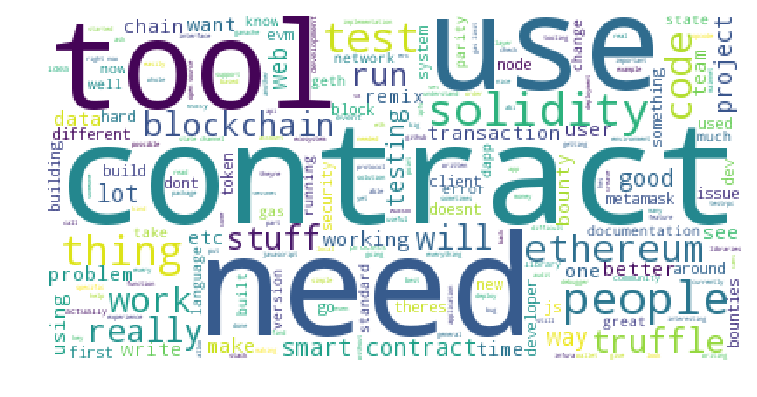

In [106]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk

cleaned = [w for doc in docs for w in doc]
wordlist = [x for x in cleaned if (len(x)>=2 and x.isalpha())]
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(" ".join(wordlist))
plt.figure(figsize=(9,6), dpi=100)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()